# CS-5824 / Advanced Machine Learning
# Assignment 2 Section B [ 40 Points ]

In this assignment, **you need to complete two sections** which are based on:

1. Decision Trees (20 points)
2. Support Vector Machines (20 points)

## Submission guidelines

1. Click the Save button at the top of the notebook.
2. Please make sure to enter your Virginia Tech PID below.
3. Select Edit -> Clear All Output. This will clear all the outputs from all cells (but will keep the content of all cells).
4. Select Runtime -> Restart and Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Print -> Save as PDF.
6. Look at the PDF file and make sure all your solutions are there and correctly displayed. 
7. Upload **both** the PDF file (saved in step 5) and this notebook.
8. Please **DO NOT** upload any data.

### Your VT PID: benakhtar

# Section 0. Environment Set Up

Mount your Google Drive in Google Colab:

In [2]:
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


Upload all files in the zip to a directory in your Google Drive, then append it to your Python path using sys (please modify `customized_path_to_your_homework` to be the path to your directory):

In [3]:
import sys
from pathlib import Path
prefix = "/content/gdrive/My Drive/"
customized_path_to_your_homework = "CS 5824 ML/HW2/"
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)
data_path = Path(sys_path) / "Data"

Run some setup code for this notebook. For all randomization done in this assignment, please use the `seed` below as the random state.

In [4]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.exceptions import ConvergenceWarning
import warnings

# We ignore the convergence warnings in this homework, as some of the exercise will
# always trigger this warning.
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Seed for all randomization
seed = 5824

# Section 1. Decision Trees [ 15 points ]

For this problem, we will use a decision tree classifier on a toy dataset provided by SciKit-Learn. We will experiment with the [Wine dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data). The data is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine. The features include:

<ol>
  <li>Alcohol</li>
  <li>Malic acid</li>
  <li>Ash</li>
  <li>Alcalinity of ash</li>
  <li>Magnesium</li>
  <li>Total phenols</li>
  <li>Flavanoids</li>
  <li>Nonflavanoid phenols</li>
  <li>Proanthocyanins</li>
  <li>Color intensity</li>
  <li>Hue</li>
  <li>OD280/OD315 of diluted wines</li>
  <li>Proline</li>
</ol>

The 3 classes are `class_0`, `class_1`, and `class_2`.

## 1.1. Data Preparation

First, we need to load the dataset from SciKit-Learn. The `load_wine()` function returns a `sklearn.utils.Bunch` object containing all information about the dataset, such as feature and target names, as well as the full description of the data in its `DESCR` property.

In [5]:
# Load dataset
from sklearn.datasets import load_wine

wine_dataset = load_wine()
feature_names = wine_dataset.feature_names
target_names = wine_dataset.target_names
wine_X, wine_y = wine_dataset.data, wine_dataset.target
print(wine_dataset.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

Normalize the data, then split it into train (80%) and test (20%) sets using the provided `seed` and with stratification:

In [6]:
# TODO: Preprocess data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

wine_x = scaler.fit_transform(wine_X)


wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X,wine_y, test_size=0.2, shuffle=True, stratify=wine_y, random_state=seed)

For ease of visualization, we will be using only the first 2 features ("Alcohol" and "Malic acid"). Visualize the train set below:

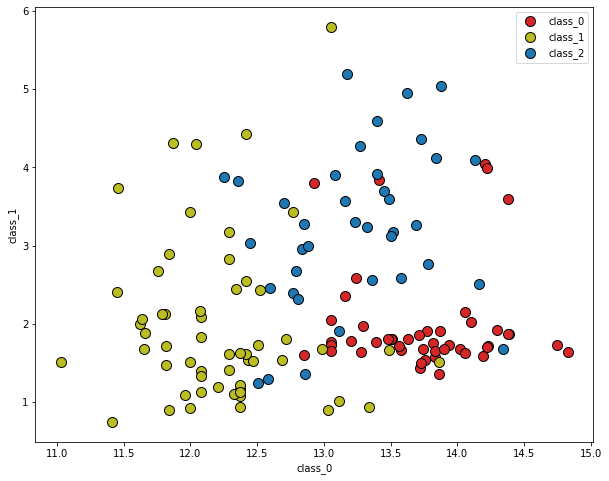

In [7]:
colors = ["tab:red", "tab:olive", "tab:blue"]
feature1, feature2 = 0, 1 # Chosen features
for label, color in zip(range(len(target_names)), colors):
    idx = np.where(wine_y_train == label)
    plt.scatter(
        wine_X_train[idx, feature1],
        wine_X_train[idx, feature2],
        s=100,
        color=color,
        edgecolor="black",
        label=target_names[label]
    )
plt.xlabel(target_names[0])
plt.ylabel(target_names[1])
plt.legend()
plt.show()

## 1.2. Training a Decision Tree (5 points)

Using [`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), train a decision tree classifier with entropy as the purity criterion, the provided `seed` as the random state, and a maximum depth of 3.

In [8]:
# TODO: Train your decision tree
from sklearn.tree import DecisionTreeClassifier

x=[]
for label, color in zip(range(len(target_names)), colors):
    idx = np.where(wine_y_train == label)
    x1=wine_X_train[idx, feature1]
    x2=wine_X_train[idx, feature2]
    label=target_names[label]

wine_X_train_split = wine_X_train[:, [feature1, feature2]]




tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth = 3, random_state=seed)
tree_clf.fit(wine_X_train_split, wine_y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=5824)

Plot your decision tree as a graph:

[Text(0.5, 0.875, 'X[0] <= 12.78\nentropy = 1.566\nsamples = 142\nvalue = [47, 57, 38]'),
 Text(0.25, 0.625, 'X[0] <= 12.44\nentropy = 0.579\nsamples = 58\nvalue = [0, 50, 8]'),
 Text(0.125, 0.375, 'X[1] <= 3.785\nentropy = 0.258\nsamples = 46\nvalue = [0, 44, 2]'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 41\nvalue = [0, 41, 0]'),
 Text(0.1875, 0.125, 'entropy = 0.971\nsamples = 5\nvalue = [0, 3, 2]'),
 Text(0.375, 0.375, 'X[1] <= 1.405\nentropy = 1.0\nsamples = 12\nvalue = [0, 6, 6]'),
 Text(0.3125, 0.125, 'entropy = 0.0\nsamples = 2\nvalue = [0, 0, 2]'),
 Text(0.4375, 0.125, 'entropy = 0.971\nsamples = 10\nvalue = [0, 6, 4]'),
 Text(0.75, 0.625, 'X[1] <= 2.23\nentropy = 1.298\nsamples = 84\nvalue = [47, 7, 30]'),
 Text(0.625, 0.375, 'X[1] <= 1.18\nentropy = 0.857\nsamples = 49\nvalue = [40, 6, 3]'),
 Text(0.5625, 0.125, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(0.6875, 0.125, 'entropy = 0.689\nsamples = 46\nvalue = [40, 3, 3]'),
 Text(0.875, 0.375, 'X[0] <= 14.18

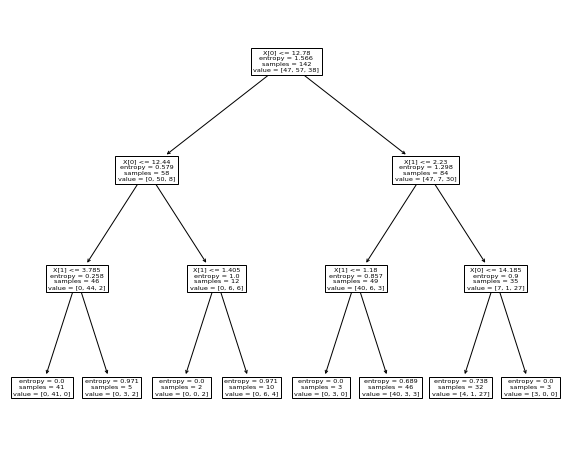

In [9]:
from sklearn.tree import plot_tree

plot_tree(tree_clf)

We can also plot the decision boundaries using the `sklearn.inspection.DecisionBoundaryDisplay` class—in particular, its `from_estimator()` method—which is [new in SciKit-Learn 1.1.2](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay). Due to package availability reasons, we include it in the attached `utils.py` file.

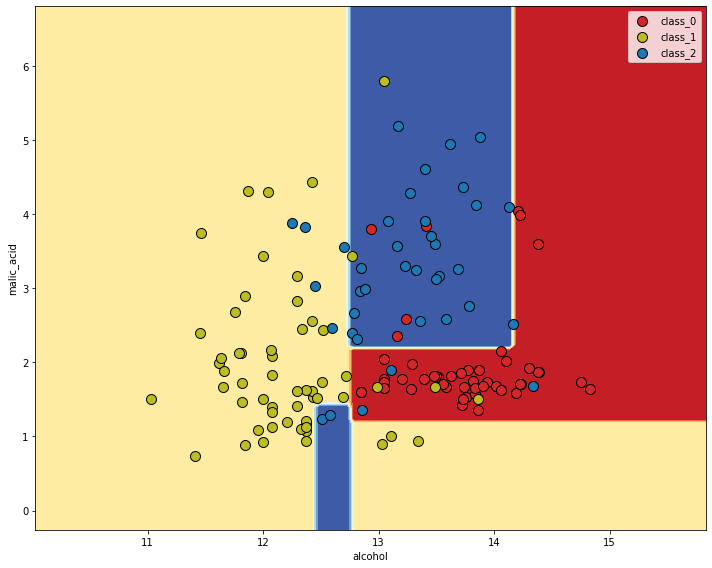

In [10]:
from utils import DecisionBoundaryDisplay

def plot_decision_boundary(clf, X, y, chosen_features, feature_names, target_names):
    feature1, feature2 = chosen_features
    fig, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        np.column_stack((X[:, feature1], X[:, feature2])),
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
    )

    for label, color in zip(range(len(target_names)), colors):
        idx = np.where(y == label)
        plt.scatter(
            X[idx, feature1],
            X[idx, feature2],
            s=100,
            color=color,
            edgecolor="black",
            label=target_names[label]
        )

    plt.xlabel(feature_names[feature1])
    plt.ylabel(feature_names[feature2])
    plt.legend()
    plt.tight_layout()

plot_decision_boundary(
    tree_clf,
    wine_X_train,
    wine_y_train,
    (feature1, feature2),
    feature_names,
    target_names
)

## 1.3. Predicting (10 points)

There are two different functions for prediction within `DecisionTreeClassifier`. 

(1) What are they? Invoke them on the test set in the cells below and look at the outputs. How are they different? How are they related? (2 points)

**_Your answer:_**

In [11]:
# TODO: Predict function 1
for label, color in zip(range(len(target_names)), colors):
    idx = np.where(wine_y_test == label)
    x1=wine_X_test[idx, feature1]
    x2=wine_X_test[idx, feature2]
    label=target_names[label]

wine_X_test_split = wine_X_test[:, [feature1, feature2]]
prediction = tree_clf.predict(wine_X_test_split)

In [12]:
# TODO: Predict function 2
for label, color in zip(range(len(target_names)), colors):
    idx = np.where(wine_y_test == label)
    x1=wine_X_test[idx, feature1]
    x2=wine_X_test[idx, feature2]
    label=target_names[label]

wine_X_test_split = wine_X_test[:, [feature1, feature2]]
prediction_proba = tree_clf.predict_proba(wine_X_test_split)

"""The first one (predict) is just predicting which class the data belongs to. The second one (predict_proba) is predicting what the probablity is that the data point is in a class"""

'The first one (predict) is just predicting which class the data belongs to. The second one (predict_proba) is predicting what the probablity is that the data point is in a class'

(2) Compute the accuracy, precision, and F1-score to assess your decision tree's performance below. How is the performance? (3 points)

**_Your answer:_**

In [13]:
# TODO: Evaluate decision tree's performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


accuracy = accuracy_score(wine_y_test,prediction)
precision = precision_score(wine_y_test, prediction, average = "weighted")
f1_score =f1_score(wine_y_test, prediction, average="weighted")

print("Accuracy: ", '%.2f'% (accuracy*100),"%")
print("Weighted average Precision: ", '%.2f'% (precision*100),"%")
print("Weighted average F1-Score: ", '%.2f'% (f1_score*100),"%")

"""Performance is okay, but ~70% feels low. It could be improved"""

Accuracy:  69.44 %
Weighted average Precision:  70.83 %
Weighted average F1-Score:  69.85 %


'Performance is okay, but ~70% feels low. It could be improved'

(3) Experiment with different parameters (*e.g.*, depth, selection criterion) and observe the change in decision boundaries as well as the evaluation scores. Report the optimal configuration and its corresponding scores. How does changing the depth improve or worsen the performance of the decision tree, specifically in the context of this dataset? (5 points)

**_Your answer:_** For the original features given, the depth selection of 2 instead of 3 improves results greatly. It seems only selecting two of the features there is not an improvement greatly in choosing a different pair of features, the original pair fares well.

# Section 2. Support Vector Machines [ 25 points ]

In this section, you will experiment with different datasets using SciKit-Learn's implementation of support vector machines (SVMs). This will give you better intuitions about utilizing SVMs when it comes to different two-dimensional datasets. You will also implement a Gaussian kernel for non-linear SVM classification.

## 2.1. Linear SVM (5 points)

In this subsection, we will experiment with a dataset that can be separated with a linear decision boundary. We want to experiment with different $C$ values to understand their effects on our linear decision boundary.

Let's first load the dataset (`svm_data1.mat` in MatLab format) using SciPy's `loadmat()` function.

In [14]:
data1 = loadmat(data_path / "svm_data1.mat")
X1, y1 = data1["X"], data1["y"][:, 0] # "X" and "y" are keys for this dataset
X1.shape, y1.shape # 2D samples + labels

((51, 2), (51,))

We provide code for plotting data and SVM decision boundaries below:

In [15]:
def plot_data(X, y, ax=None):
    """Plot 2D dataset."""
    positive = (y == 1)
    negative = (y == 0)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(X[positive, 0], X[positive, 1], "X", mew=1, ms=10, mec="k")
    ax.plot(X[negative, 0], X[negative, 1], "o", mew=1, mfc="tab:olive", ms=10, mec="k")


def plot_linear_boundary(X, y, model, ax=None):
    """Plot linear boundary."""
    if model is None:
        return
    w = model.coef_[0]    # the theta of your SVM classifier
    b = model.intercept_  # the bias of your SVM classifier
    xp = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
    yp = -(w[0] * xp + b) / w[1]
    if ax is None:
        fig, ax = plt.subplots()
    plot_data(X, y, ax)
    ax.plot(xp, yp)
    
    
def plot_nonlinear_boundary(X, y, model, ax=None):
    """Contour plot that delineates a nonlinear boundary."""
    if model is None:
        return
    num_points = X.shape[0]
    x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), num_points)
    x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), num_points)
    X1, X2 = np.meshgrid(x1, x2)
    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        X_ = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = model.predict(X_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.contourf(X1, X2, vals, cmap="YlGnBu", alpha=0.2)    
    plot_data(X, y, ax)

We want to first visualize our dataset in two-dimensional space:

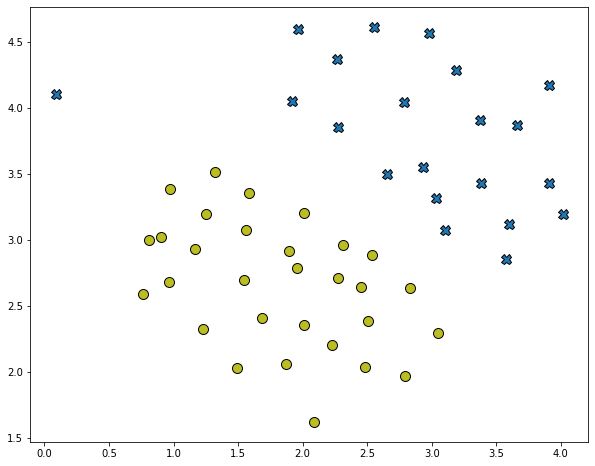

In [16]:
# Plot training data
plot_data(X1, y1)

(1) Describe the dataset. How does it lend itself well to the use of an SVM? Are there any abnormalities that may affect our model's performance? (2 points)

The dataset lends itself well to an SVM because there is a clear deicision boundary between the data. There is 1 abnormality in the blue X's that could affect our performance.

Now, we want to train linear SVMs for our dataset. You should pick **6 different $C$ values** to train your SVMs, then plot all of them side by side for convenient juxtaposition. You should train your models with **L2 penalty** and **hinge loss**. Use the provided `seed`. We provide code for side-by-side plots below.

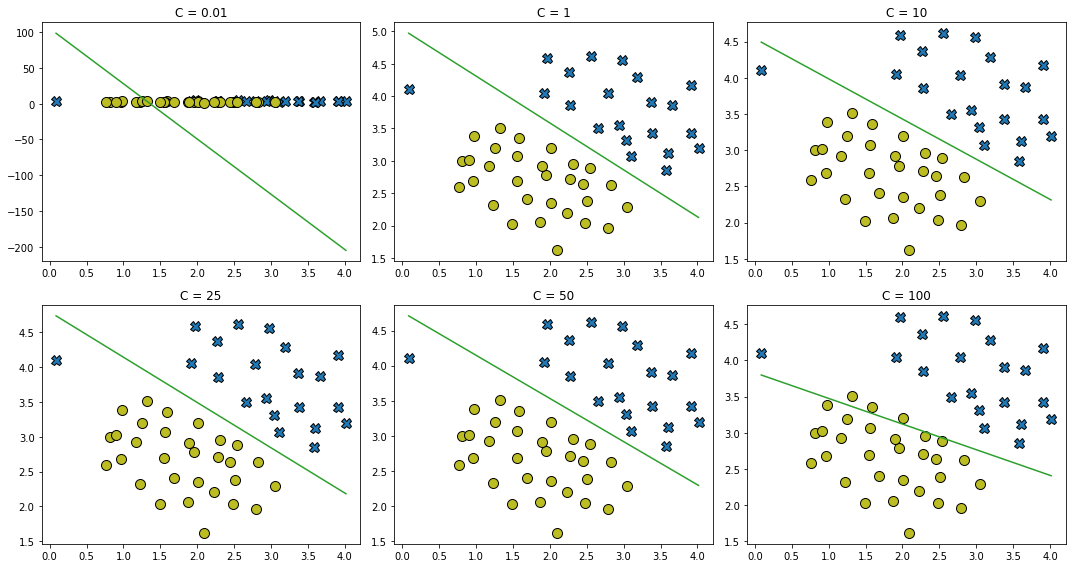

In [17]:
import math
from sklearn.svm import LinearSVC

# TODO: Replace None's with appropriate values
Cs = [.01, 1, 10, 25, 50, 100]

cols = 3
rows = math.ceil(len(Cs) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
for row in range(rows):
    for col in range(cols):
        C = Cs[row * cols + col]
        # TODO: Train SVM
        model = LinearSVC(penalty='l2',loss='hinge',C=C,random_state=seed)
        svm_clf = model.fit(X1, y1)
        # End of code
        plot_linear_boundary(X1, y1, svm_clf, axes[row, col])
        axes[row, col].set_title(f"C = {C}")
plt.tight_layout()

(2) What does $C$ intuitively represent, and how does varying it affect our SVM's decision boundary, according to the graphs? Take into account any abnormalities mentioned above. (3 points)

**_Your answer:_** The C value represents how much we want to avoid misclassifying an example or rather what margin the hyperplane should be. The lower C values fit the data points together, whereas the larger C values spread out the data points more and have more influence by outliers. 

## 2.2. Kernel SVM (20 points)

In this part of the homework, you will perform non-linear classification using SVMs, with Gaussian kernels in particular.

### 2.2.1. Gaussian Kernel (10 points)

Similarly to Gaussian basis functions, we can use Gaussian kernels to find non-linear decision boundaries. As mentioned in lectures and chapter 6.2 of the Bishop textbook (page 296), these kernels are of the form:

$$
    k(\mathbf{x}, \mathbf{x}') = \exp \left\{ -\frac{\lVert\mathbf{x} - \mathbf{x}'\rVert^2}{2\sigma^2}\right\}
$$

Implement a Gaussian kernel matrix for our SVMs below. We will be using [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) as our model.

In [18]:
from sklearn.metrics.pairwise import rbf_kernel

def gaussian_kernel(x, x_prime, sigma):
    k = None
    # TODO: Implement Gaussian kernel matrix
    gamma = 1/(2*sigma*sigma)
    k = rbf_kernel(x, x_prime, gamma)
    # End of code
    return k


Note that according to [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), our resulting kernel matrix should have size `(n_samples, n_samples)`. Once you have completed the implemetation of `gaussian_kernel_matrix()`, the following cell will test your kernel function on two provided examples, after which you should expect to see a value of:

<pre>
[[1.         0.32465247]
 [0.32465247 1.        ]]
</pre>

In [19]:
x1 = np.array([[1, 2, 1],[0, 4, -1]])
x2 = np.array([[1, 2, 1],[0, 4, -1]])
sigma = 2.0

kernel_matrix = gaussian_kernel(x1, x2, sigma)
print(kernel_matrix)

[[1.         0.32465247]
 [0.32465247 1.        ]]


### 2.2.2. Training SVM with a Gaussian Kernel (5 points)

Let's demonstrate a Gaussian-kernel SVM on a non-linear dataset:

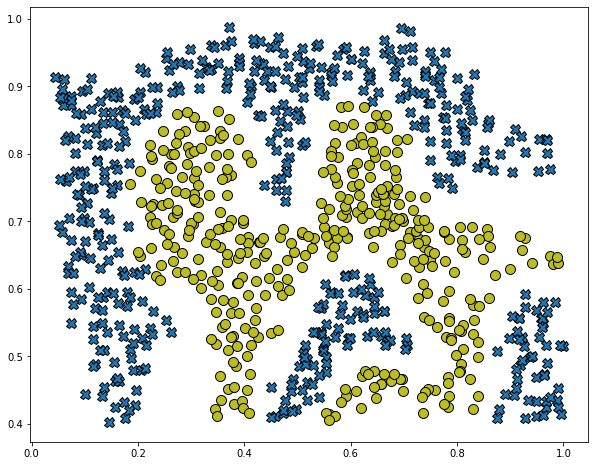

In [20]:
data2 = loadmat(data_path / "svm_data2.mat")
X2, y2 = data2["X"], data2["y"][:, 0]
plot_data(X2, y2)

Apply a Gaussian kernel to your non-linear SVC model below; an SVC example with a custom kernel is available [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html). Note the kernel's input arguments.

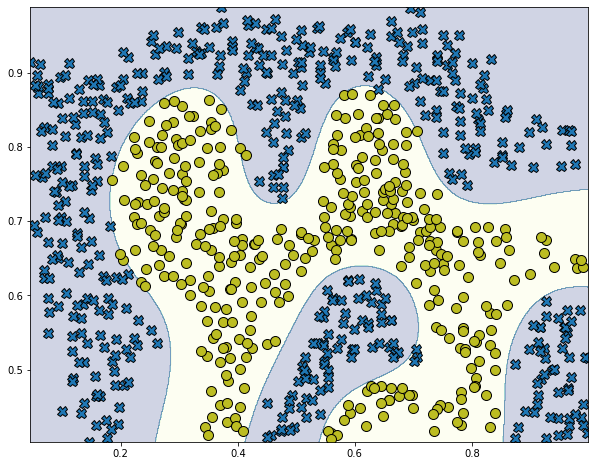

In [21]:
sigma = 0.1
# TODO: Apply Gaussian kernel on SVC with provided seed as random_state
def kernel_wrapper(f, sigma):
    return lambda x, x_prime: f(x, x_prime, sigma)
from sklearn import svm
model_gaussian = svm.SVC(kernel=kernel_wrapper(gaussian_kernel,sigma),random_state=seed)
model_gaussian.fit(X2,y2)
# End of code
plot_nonlinear_boundary(X2, y2, model_gaussian) # note that this step could take up to 1 minute

### 2.2.3. Grid Search Cross Validation (5 points)

In this part of the homework, you will utilize cross validation with a validation set to finetune your model. You will use Gaussian-kernel SVMs for this task. From the provided dataset (`svm_data3.mat`), you are given a train and validation set:

Text(0.5, 1.0, 'Validation set')

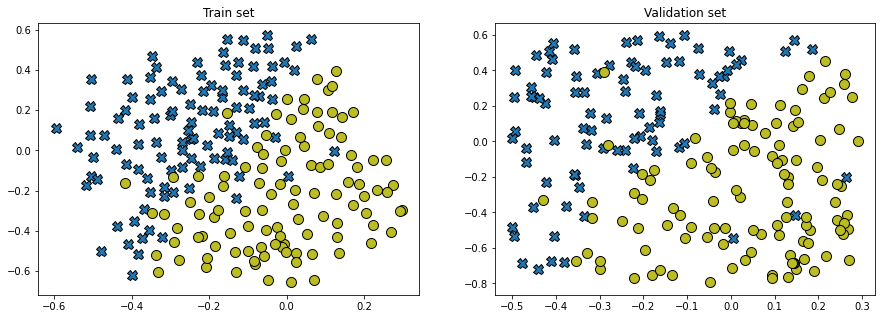

In [22]:
data3 = loadmat(data_path / "svm_data3.mat")

X_train = data3["X"]
y_train = data3["y"][:, 0]
X_val = data3["Xval"]
y_val = data3["yval"][:, 0]

# Plot training and validation data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_data(X_train, y_train, ax1)
plot_data(X_val, y_val, ax2)
ax1.set_title("Train set")
ax2.set_title("Validation set")

Here, you are to use the validation set (`X_val`, `y_val`) to determine the best combination of $C$ and $\sigma$ parameters for your SVM, using accuracy as your metric. We suggest trying values in multiplicative steps for these parameters (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30). You should try all possible pairs of values for $C$ and $\sigma$. For example, trying every possible combination of the 2 parameters among the 8 values listed above would result in $8^2 = 64$ different models being trained and validated. Because this could take a long time, we suggest reserving time to work on this section.

Write code to determine the best combination of $C$ and $\sigma$ as well as to return the corresponding values in `search_hyperparameter()` below.

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
def search_hyperparameter(X_train, y_train, X_val, y_val, Cs, sigmas):
    # TODO: Grid search
    kernels = [kernel_wrapper(gaussian_kernel, sigma) for sigma in sigmas]
    param_grid = {'C': Cs ,'kernel': kernels}
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
    grid = GridSearchCV(SVC(),param_grid=param_grid, cv=cv)
    grid.fit(X_val, y_val)
    sigma_index = kernels.index(grid.best_params_.get('kernel'))
    sigma = sigmas[sigma_index]
    C = grid.best_params_.get('C')
    return grid.best_score_, C, sigma

Report the best performing parameters along with the accuracy score on `X_val`. You should be able to get an accuracy higher than 0.9. The optimal parameters may not be unique.

In [45]:
Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigmas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
# TODO: Try different SVM hyperparameters
best_accuracy, C, sigma = search_hyperparameter(X_train, y_train, X_val, y_val, Cs, sigmas)
print("Results from Grid Search")
print("The best accuracy is: ", best_accuracy)
print("The best C value is: ", C)
print("The best sigma value is: ", sigma)

Results from Grid Search
The best accuracy is:  0.95
The best C value is:  30
The best sigma value is:  0.3


Lastly, train the model again with your optimal parameters and plot the decision boundary.

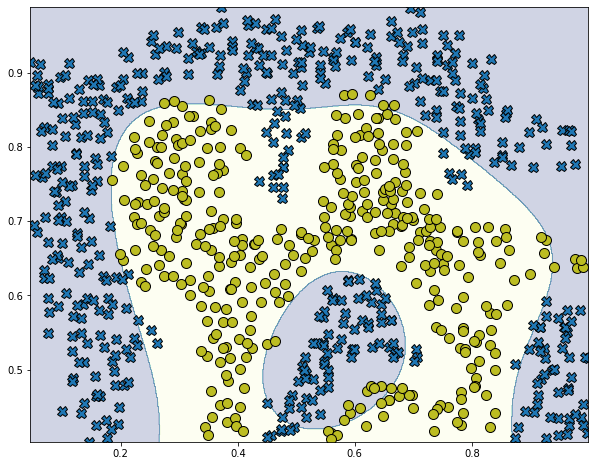

In [50]:
# TODO: Train and plot model with best configuration
model_gaussian = svm.SVC(kernel=kernel_wrapper(gaussian_kernel,sigma),C = C, random_state=seed)
model_gaussian.fit(X2,y2)
plot_nonlinear_boundary(X2, y2, model_gaussian) # note that this step could take up to 1 minute